## Implémentation de l'algorithme **AdaBoost** basé sur des *Decision Stumps*. 

### Voir chapitre 10 du livre *Understanding Machine Learning* de S. Shalev-Shwartz et S. Ben-David

In [1]:
using Plots, ProgressMeter, LinearAlgebra
gr()

Plots.GRBackend()

## Initialize the test case

In [2]:
m, d  = 1000, 2
coef3 = 2 * rand(d,d,d) .- 1
coef2 = 2 * rand(d,d) .- 1
coef1 = 2 * rand(d,1)
coef0 = rand(1)

1-element Array{Float64,1}:
 0.21709530357252227

In [3]:
struct Stump
    
    j :: Int64
    theta :: Float64
    b :: Float64
    
    function Stump(j, theta, b)
        @assert j > 0
        new(j, theta, b)
    end
    
end

function (self :: Stump)( x )
    self.b * sign.(self.theta .- x[:,self.j])
end
    
function erreur(self :: Stump, x, y, D)
    sum( D .* (y .!= self(x)))
end

erreur (generic function with 1 method)

In [4]:
mutable struct Hypotheses
    
    weights :: Vector{Float64}
    stumps  :: Array{Stump,1}
    D       :: Vector{Vector{Float64}}
    
    function Hypotheses( )
        weights = Float64[]
        stumps  = Stump[]
        D       = Vector{Float64}[]
        new( weights, stumps, D)
    end
    
end

function (self::Hypotheses)(x)
    T = length(self.weights)
    m = size(x)[1]
    s = zeros(Float64, m )
    for t in 1:T
        s .+= self.weights[t] .* self.stumps[t](x)
    end
    sign.(s)
end

function erreur(self,x,y)
    m = length(y)
    sum(self(x) .!= y)/m
end

erreur (generic function with 2 methods)

In [5]:
function plot_results( x, y, ytest)
    
    p    = plot(layout=(1,2); )
    blue = y .< 0
    red  = y .> 0
    scatter!(p[1,1],x[red,1],x[red,2],label=:Xb, title=:test)
    scatter!(p[1,1],x[blue,1],x[blue,2],label=:or)
    blue = ytest .< 0
    red  = ytest .> 0
    scatter!(p[1,2],x[red,1],x[red,2],label=:Xb, title=:test)
    scatter!(p[1,2],x[blue,1],x[blue,2],label=:or)
    p
    
end

plot_results (generic function with 1 method)

La fonction suivante résout le problème Empirical Risk Minimization pour la classe des Decisions Stumps : il calcule 

$${\rm argmin}_{h\in {\rm Stump}}\sum_{i=1}^mD_i \mathbb 1(h(x_i)\neq y_i)$$

In [6]:
function ERM_Stump( x :: Array{Float64,2},
                    y :: Vector{Float64},
                    D :: Vector{Float64})
    m, d       = size(x)
    Fstar      = 1e15
    F          = Fstar
    bstar      = 1
    thetastar  = 0.
    jstar      = 1
    indice_tri = hcat([sortperm(x[:,j]) for j in 1:d]...) #np.argsort(x,axis=0)
    xsort      = zeros(Float64,m+1)
    for j in 1:d
        xsort[1:m] = x[indice_tri,j][:,j]
        xsort[end] = xsort[m]+1
        ysort = y[indice_tri[:,j]]
        Dsort = D[indice_tri[:,j]]
        F = sum(Dsort .* (ysort .+ 1)/2)
        if F < Fstar
            bstar = 1
            Fstar = F
            thetastar = xsort[1] - 1
            jstar = j
        end
        for i in 1:m
            F = F - ysort[i] * Dsort[i]
            if F < Fstar && xsort[i] < xsort[i+1]
                bstar=1
                Fstar=F
                thetastar=(xsort[i]+xsort[i+1])/2
                jstar=j
            end
        end
        F = sum(Dsort .* (1 .- ysort)/2)
        if F < Fstar
            bstar = -1
            Fstar = F
            thetastar = xsort[1]-1
            jstar = j
        end
        for i in 1:m
            F = F + ysort[i] * Dsort[i]
            if F < Fstar && xsort[i]<xsort[i+1]
                bstar = -1
                Fstar = F
                thetastar = (xsort[i]+xsort[i+1])/2
                jstar = j
            end
        end
    end
    Stump(jstar, thetastar, bstar)
end

ERM_Stump (generic function with 1 method)

## Cas test 1

Première série de données, $d=2$, on tire un polynôme $P(x_1,x_2)$ de degré 3 et pour tout $x\in \mathbb R^2$, on prend $f(x)={\rm sign\,}P(x)$

In [7]:
function generate_data(m, d)
    x = 2 * rand(m,d) .- 1
    y = zeros(Float64,m)
    for i in 1:d, j in 1:d, k in 1:d
        y .+= coef3[i,j,k] .* x[:,i] .* x[:,j] .* x[:,k]
    end
    y = sign.(y .+ diag((x * coef2) * transpose(x)) .+ x * coef1 .+ coef0);
    x, vec(y)
end

x, y = generate_data(m, d)

([-0.433433 0.411548; -0.406434 -0.884818; … ; 0.92116 0.476843; 0.888984 -0.0742198], [-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0])

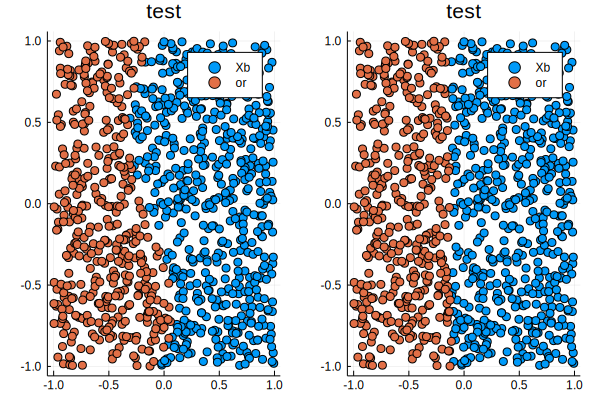

In [8]:
#d = 2
#m = 1000
#f = open("test1.txt")
#data = [ transpose(map(x->parse(Float64,x),split(line," "))) for line in eachline(f)]
#data = vcat(data...)
#
#x = data[:,1:2]
#y = data[:,3]


D = 1 / m .* ones(Float64, m)
h = ERM_Stump(x,y,D)
plot_results( x, y, h(x))

La fonction suivante implémente l'algorithme AdaBoost, sur les données $(x_i,y_i)_{1\leq i\leq m}$, avec $T$ itérations et avec le classifieur faible weak_learner (qui peut être par exemple ERM_Stump). 

Il renvoie l'hypothèse $H$, la suite des erreurs successives du classifieur fort et la suite des erreurs successives des classifieurs faibles obtenus au fur et à mesure des itérations.

In [9]:
function adaboost( x, y , T)
    
    m = size(x)[1]
    D = 1 / m * ones(Float64,m)
    H = Hypotheses()
    epsilon = Float64[]
    
    @showprogress 1 for t in 1:T
        ht = ERM_Stump(x, y, D)
        hx = ht(x)
        e  = erreur(ht, x, y, D)
        w0 = 0.5 * log(1 / e-1)
        push!(epsilon, e)
        push!(H.weights, w0)
        push!(H.stumps, ht)
        #push!(H.D, D)
        D = D .* exp.(-w0 * y .* hx)
        D = D / sum(D)
    end
    H, epsilon
end

adaboost (generic function with 1 method)

Ci-dessous, on affiche à gauche les données d'entraînement et à droite le résultat de la classification des mêmes données d'entraînement par le résultat d'AdaBoost

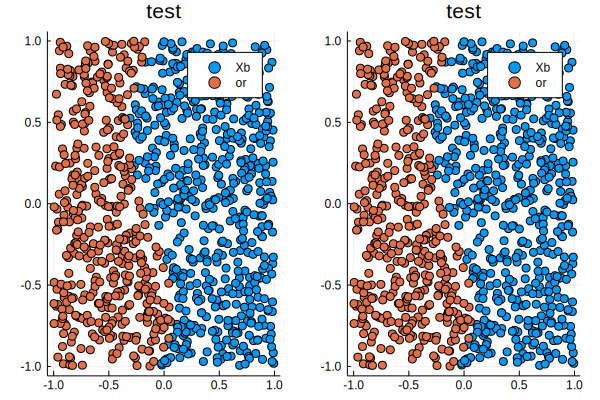

In [10]:
H, epsilon = adaboost( x, y, 100)
yresult = H(x)
plot_results( x, y, yresult)

In [11]:
a=100*(1-erreur(H,x,y))
println("Performance sur les données de test :",a[1],"%")

Performance sur les données de test :100.0%

Ci-dessous, on affiche à gauche les données de test et à droite le résultat de la classification des mêmes données de test par le résultat d'AdaBoost

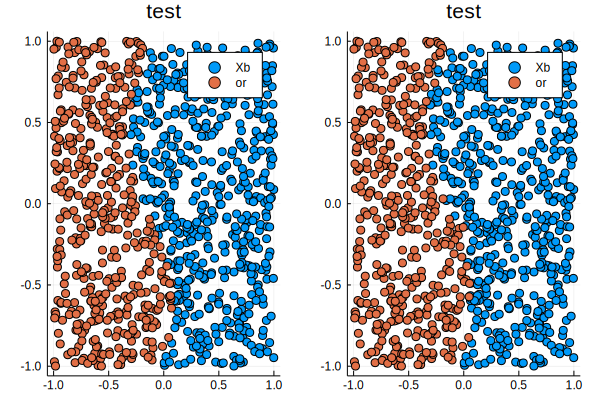

In [12]:
xtest, ytest = generate_data(m, d)
plot_results( xtest, ytest, H(xtest))

In [13]:
a=100*(1-erreur(H,xtest,ytest))
println("Performance sur les données de test :",a[1],"%")

Performance sur les données de test :98.7%

Ci-dessous, on affiche l'erreur de l'algorithme AdaBoost (en pourcentages) au cours des itérations

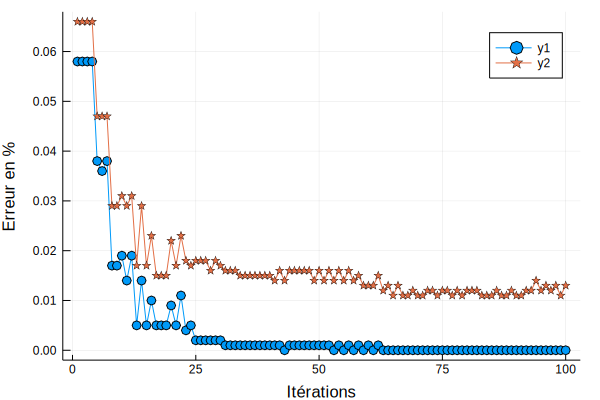

In [14]:
err       = Float64[]
err0      = zeros(Float64,m)
err_test  = Float64[]
err_test0 = zeros(Float64,m)
for (weight, stump)  in zip(H.weights, H.stumps)
    err0 .+= weight .* stump(x)
    push!(err, sum( sign.(err0) .!= y) / m)
    err_test0 .+= weight .* stump(xtest)
    push!(err_test, sum(sign.(err_test0) .!= ytest) / m)
end

plot(err; marker=:o)
plot!(err_test; marker=:s)
xlabel!("Itérations")
ylabel!("Erreur en %")

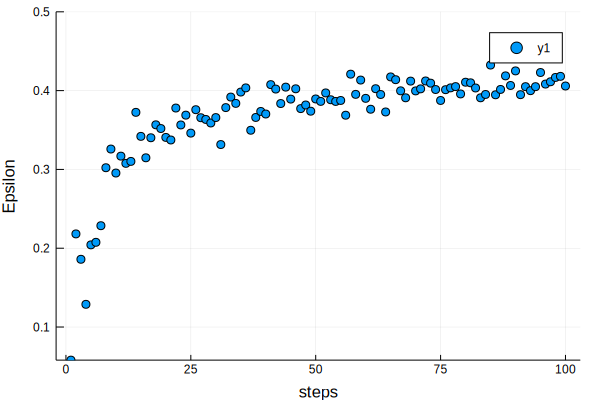

In [15]:
scatter(epsilon)
xlabel!("steps")
ylabel!("Epsilon")
ylims!(minimum(epsilon), 0.5)

## Cas test 2

Deuxième série de données, issues du UCI machine learning repository : https://archive.ics.uci.edu/ml/datasets/banknote+authentication

Ce sont des données sur des billets de banque. Pour chaque billet, on a 5 données, dans l'ordre : Variance of Wavelet Transformed Image, Skewness of Wavelet Transformed image, Curtosis of Wavelet Transformed image, Entropy of image, Class (Class contains two values 0 representing genuine note and 1 representing fake note)

In [16]:
f = open("data_banknote_authentication.txt")
databrute = [ transpose(map(x->parse(Float64,x),split(line,","))) for line in eachline(f)]
data = vcat(databrute...);

In [17]:
@show n = size(data)[1]
print("Pourcentage de vrais billets :",(n-sum(data[:,5]))/n*100,"%")

n = (size(data))[1] = 1372
Pourcentage de vrais billets :55.539358600583085%

In [18]:
using Random
taille       = n
taille_train = trunc(Int64,taille*0.8)
taille_test  = taille-taille_train
indice       = randperm(taille)
train        = data[indice[1:taille_train],:]
test         = data[indice[taille_train+1:end],:]
xtrain       = train[:,1:4]
ytrain       = 2 * train[:,5] .- 1
xtest        = test[:,1:4]
ytest        = 2 * test[:,5] .- 1
d            = 4
m            = taille_train

1097

In [19]:
H, epsilon = adaboost(xtrain, ytrain, 50)

(Hypotheses([0.894817, 0.59771, 0.647861, 0.532932, 0.57077, 0.507923, 0.45953, 0.479409, 0.381452, 0.44721  …  0.294945, 0.287085, 0.286274, 0.31088, 0.282979, 0.30695, 0.24514, 0.247483, 0.262951, 0.223177], Stump[Stump(1, 0.320165, 1.0), Stump(2, 5.2353, 1.0), Stump(1, -2.7952, 1.0), Stump(3, 0.19121, 1.0), Stump(2, 5.2353, 1.0), Stump(1, -1.51475, 1.0), Stump(1, 1.74605, 1.0), Stump(3, -1.74435, 1.0), Stump(2, 0.65595, 1.0), Stump(3, 1.8016, 1.0)  …  Stump(2, -0.032083, 1.0), Stump(3, 3.02265, 1.0), Stump(2, -6.47685, 1.0), Stump(1, 2.3921, 1.0), Stump(1, -2.7952, 1.0), Stump(2, 6.99105, 1.0), Stump(1, -1.3636, 1.0), Stump(3, 4.5671, 1.0), Stump(2, -3.3481, 1.0), Stump(3, -1.3395, 1.0)], Array{Float64,1}[]), [0.143118, 0.232291, 0.214886, 0.25619, 0.242038, 0.265837, 0.285149, 0.277115, 0.318016, 0.290199  …  0.35666, 0.360275, 0.360649, 0.349381, 0.36217, 0.35117, 0.379828, 0.378724, 0.371473, 0.390228])

In [20]:
yresult     =  H(xtrain)
yresulttest =  H(xtest);

In [21]:
a=100*(1 .- erreur(H,xtrain,ytrain))
print("Performance sur les données d'entraînement :",a[1],"%")

Performance sur les données d'entraînement :100.0%

In [22]:
a=100*(1-erreur(H,xtest,ytest))
print("Performance sur les données de test :",a[1],"%")

Performance sur les données de test :100.0%

Ci-dessous, on affiche l'erreur de l'algorithme AdaBoost (en pourcentages) au cours des itérations

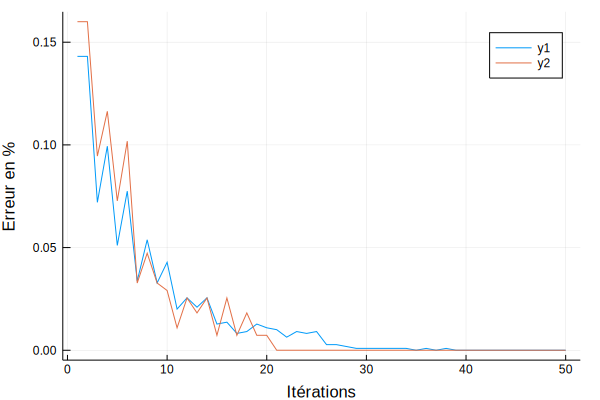

In [23]:
nt        = length(H.stumps)
err       = Float64[]
err0      = zeros(Float64,length(ytrain))
err_test  = Float64[]
err_test0 = zeros(Float64,length(ytest))

for i in 1:nt
    err0 .+= H.weights[i] .* H.stumps[i](xtrain)
    push!(err, sum(sign.(err0) .!= ytrain) / length(ytrain))
    err_test0 .+= H.weights[i] .* H.stumps[i](xtest)
    push!(err_test, sum(sign.(err_test0) .!= ytest)/length(ytest))
end

plot(err)
plot!(err_test)
xlabel!("Itérations ")
ylabel!("Erreur en %")

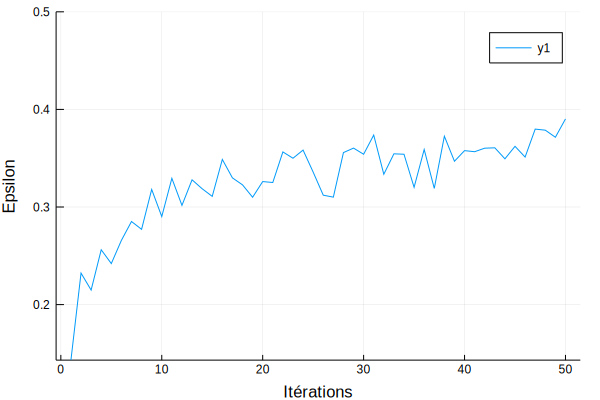

In [24]:
plot(epsilon)
xlabel!("Itérations")
ylabel!("Epsilon")
ylims!(minimum(epsilon), 0.5)

In [25]:
print("borne d'erreur théorique ",exp(-2*sum((1/2 .- epsilon).^2))*100,"%")

borne d'erreur théorique 3.94633996702429%

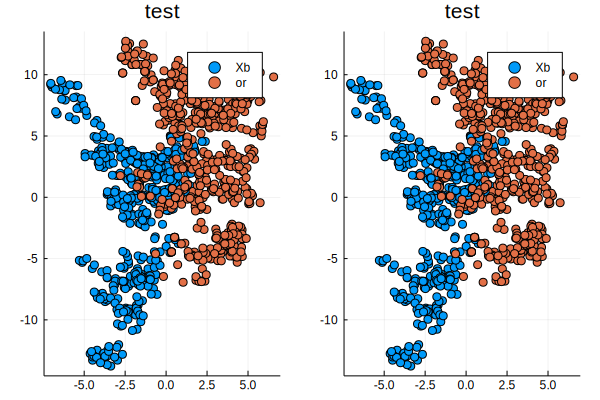

In [26]:
plot_results(xtrain, ytrain, yresult)

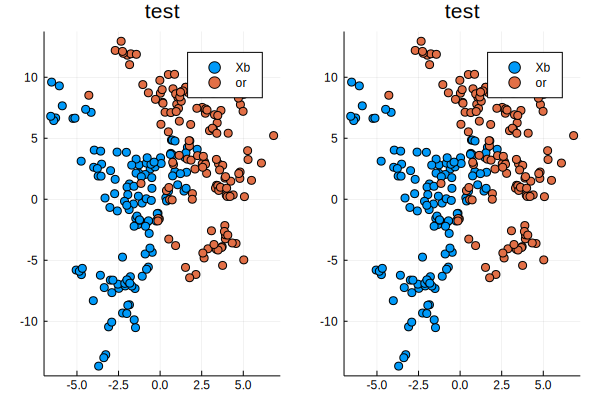

In [27]:
plot_results(xtest, ytest, yresulttest)

## Cas test 3

Troisième série de données, issues du UCI machine learning repository : https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State

Chaque ligne a 15 attributs. Les 14 premiers sont des mesures d'ElectroEncéphaloGrammes et le 15ème est un indicateur disant si le patient avait les yeux ouverts ou fermés.

In [28]:
f = open("EEG_Eye_State.txt")

IOStream(<file EEG_Eye_State.txt>)

In [29]:
databrute = [ transpose(map(x->parse(Float64,x),split(line,","))) for line in eachline(f)]
data = vcat(databrute...)

n = size(databrute)[1]
println("Nombre de données : ", n)

count = sum( data[:,15] .== 0)
println("Pourcentage de classe 0 :",count/n*100,"%")

Nombre de données : 14980
Pourcentage de classe 0 :55.12016021361815%


In [30]:
n_train  = trunc(Int64,n/3)
n_valid  = trunc(Int64,n/3)
n_test   = n-n_train-n_valid
indice   = randperm(n)
train    = data[indice[1:n_train],:]
valid    = data[indice[n_train+1:n_train+n_valid],:]
test     = data[indice[n_train+n_valid+1:end],:]
x        = train[:,1:14]
y        = 2 * train[:,15] .- 1
xvalid   = valid[:,1:14]
yvalid   = 2 * valid[:,15] .- 1
xtest    = test[:,1:14]
ytest    = 2 * test[:,15] .- 1
d        = 14
m        = n_train

4993

In [31]:
(H,epsilon)=adaboost(x,y,2000)

yresult     = H(x)
yresulttest = H(xtest)

a = sum(yresult .== y) / m * 100
println("Performance sur les données d'entraînement :",a[1],"%")

a = sum(yresulttest .== ytest) / n_test*100
println("Performance sur les données de test :",a[1],"%")

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


Performance sur les données d'entraînement :81.03344682555577%
Performance sur les données de test :74.46936323588305%


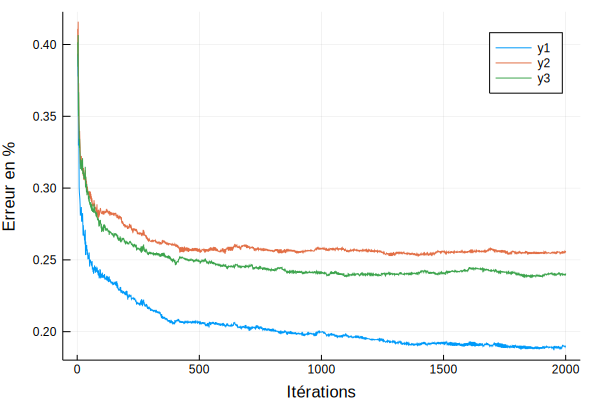

In [36]:
err        = Float64[]
err0       = zeros(Float64,length(y))
err_valid  = Float64[]
err_valid0 = zeros(Float64,length(yvalid))
err_test   = []
err_test0  = zeros(Float64,length(ytest))
nt = length(H.stumps)
for i in 1:nt
    err0 .+= H.weights[i] .* H.stumps[i](x)
    push!(err, sum(sign.(err0) .!= y) / length(y))
    err_test0 .+= H.weights[i] .* H.stumps[i](xtest)
    push!(err_test, sum(sign.(err_test0) .!= ytest) / length(ytest))
    err_valid0 .+= H.weights[i]*H.stumps[i](xvalid)
    push!(err_valid,sum(sign.(err_valid0) .!= yvalid) / length(yvalid))
end

plot(err)
plot!(err_test)
plot!(err_valid)
xlabel!("Itérations")
ylabel!("Erreur en %")

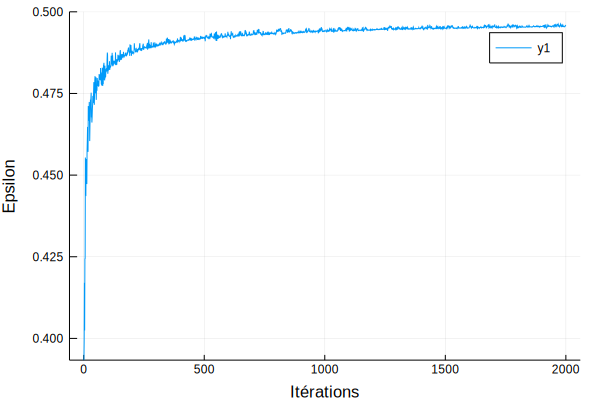

In [37]:
plot(epsilon)
xlabel!("Itérations")
ylabel!("Epsilon")
ylims!(minimum(epsilon), 0.5)

In [38]:
println("borne d'erreur théorique : ",exp(-2*sum((1/2 .- epsilon).^2))*100,"%")

borne d'erreur théorique : 64.87897930213371%


In [39]:
i = argmin(err_valid)
println(i)
println(err_test[i])
println(minimum(err_valid))

1100
0.2569082899479375
0.23813338674143802
